In [1]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.4 MB/s eta 0:00:00


In [2]:
!pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 17.5 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=3902220ac964ea8bc5623a1218b543420ffb56ff28b0c272364965c21f3d8de8
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11335 sha256=c084821bc85639ddf43aeae3ac619921dd0bf6a6ed7722a1d5b9430b4fbcf04a
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [13]:
# importing libraries

import pandas as pd
import numpy as np
import seaborn as sns

# keeps the plots in one place. calls image as static pngs
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
import matplotlib.gridspec as gridspec # subplots

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score, accuracy_score, roc_auc_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from fancyimpute import SoftImpute
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [4]:
X_train = pd.read_csv('X_train.csv')
X_train

,Unique_ID,C1,C2,C3,C4,C5,C6,C7,C8,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N10.1,N11,N12,N14,N15,N16,N17,N18,N19,N20,N21,N22,N23,N24,N25,N26,N27,N28,N29,N30,N31,N32,N33,N34,N35
0,Candidate_5926,1,0,11,31,0,False,0,True,23.75,NaN,2.5,NaN,NaN,2.595,10.0,0,0,2.0,14.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.816,1750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.00,113.39,12.0
1,Candidate_48134,1,4,2,66,2,False,1,True,11.05,22.0,3.7,16.0,12.0,3.795,19.0,4,72,0.0,5.0,9.0,0.0,0.0,0.0,0.0,1944.0,0.06,25856.0,17.0,0.88,1.0,40.000,10833.333330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.00,262.10,17.0
2,Candidate_51717,1,0,19,2,0,False,0,True,29.00,NaN,2.4,NaN,NaN,2.495,17.0,2,15,7.0,3.0,19.0,NaN,10.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.000,6250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.00,50.29,18.0
3,Candidate_26401,1,1,16,47,1,False,4,True,17.99,1.0,3.5,4.0,4.0,3.595,6.0,5,190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8244.0,0.89,1006.0,6.0,1.00,0.0,26.000,2413.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.00,126.52,27.0
4,Candidate_34872,1,1,13,1,1,True,6,True,27.50,206.0,3.8,11.0,11.0,3.895,31.0,10,1504,0.0,1.0,4.0,0.0,0.0,0.0,0.0,57532.0,0.97,3398.0,31.0,0.96,0.0,44.000,7666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,205.47,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33045,Candidate_26099,1,1,14,41,2,False,6,True,15.50,19.0,3.1,7.0,6.0,3.195,7.0,6,303,0.0,0.0,8.0,0.0,0.0,0.0,0.0,16762.0,0.68,7661.0,7.0,1.00,0.0,18.000,7000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,199.98,349.07,8.0
33046,Candidate_33316,1,6,10,1,2,True,2,True,32.20,42.0,3.1,12.0,11.0,3.195,50.0,7,225,2.0,1.0,8.0,2135.0,33.0,1.0,0.0,6551.0,0.86,868.0,41.0,0.63,2.0,42.000,4420.000000,1.0,6.0,6.0,0.0,0.0,3000.0,2637.56,0.0,40.00,87.33,19.0
33047,Candidate_36027,1,1,2,4,2,False,6,True,8.99,137.0,3.7,14.0,14.0,3.795,30.0,13,297,0.0,1.0,1.0,31.0,2.0,0.0,0.0,7809.0,0.27,20105.0,28.0,0.75,0.0,18.000,6971.833333,1.0,11.0,10.0,1.0,0.0,15000.0,0.03,66.0,40.00,63.59,20.0
33048,Candidate_3169,1,0,0,0,0,False,0,True,15.00,NaN,2.7,NaN,NaN,2.795,29.0,5,165,4.0,6.0,19.0,NaN,40.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.000,2537.916667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.00,41.60,17.0


In [5]:
y_train = pd.read_csv('y_train.csv')
y_train

,Unique_ID,Dependent_Variable
0,Candidate_5926,1
1,Candidate_48134,0
2,Candidate_51717,1
3,Candidate_26401,0
4,Candidate_34872,0
...,...,...
33045,Candidate_26099,0
33046,Candidate_33316,0
33047,Candidate_36027,0
33048,Candidate_3169,1


Missing Data

In [6]:
all_data_na = (X_train.isnull().sum() / len(X_train))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending = False)
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data           # Ratio of data points for each column with null values

,Missing Ratio
N32,81.180030
N31,81.025719
N30,81.025719
N29,81.025719
N28,81.025719
N27,81.025719
N26,81.025719
N25,81.025719
N12,13.960666
N2,13.954614


In [7]:
df = y_train.merge(X_train, how = "left", on = "Unique_ID")
df

,Unique_ID,Dependent_Variable,C1,C2,C3,C4,C5,C6,C7,C8,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N10.1,N11,N12,N14,N15,N16,N17,N18,N19,N20,N21,N22,N23,N24,N25,N26,N27,N28,N29,N30,N31,N32,N33,N34,N35
0,Candidate_5926,1,1,0,11,31,0,False,0,True,23.75,NaN,2.5,NaN,NaN,2.595,10.0,0,0,2.0,14.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.816,1750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.00,113.39,12.0
1,Candidate_48134,0,1,4,2,66,2,False,1,True,11.05,22.0,3.7,16.0,12.0,3.795,19.0,4,72,0.0,5.0,9.0,0.0,0.0,0.0,0.0,1944.0,0.06,25856.0,17.0,0.88,1.0,40.000,10833.333330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.00,262.10,17.0
2,Candidate_51717,1,1,0,19,2,0,False,0,True,29.00,NaN,2.4,NaN,NaN,2.495,17.0,2,15,7.0,3.0,19.0,NaN,10.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.000,6250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.00,50.29,18.0
3,Candidate_26401,0,1,1,16,47,1,False,4,True,17.99,1.0,3.5,4.0,4.0,3.595,6.0,5,190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8244.0,0.89,1006.0,6.0,1.00,0.0,26.000,2413.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.00,126.52,27.0
4,Candidate_34872,0,1,1,13,1,1,True,6,True,27.50,206.0,3.8,11.0,11.0,3.895,31.0,10,1504,0.0,1.0,4.0,0.0,0.0,0.0,0.0,57532.0,0.97,3398.0,31.0,0.96,0.0,44.000,7666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,205.47,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33045,Candidate_26099,0,1,1,14,41,2,False,6,True,15.50,19.0,3.1,7.0,6.0,3.195,7.0,6,303,0.0,0.0,8.0,0.0,0.0,0.0,0.0,16762.0,0.68,7661.0,7.0,1.00,0.0,18.000,7000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,199.98,349.07,8.0
33046,Candidate_33316,0,1,6,10,1,2,True,2,True,32.20,42.0,3.1,12.0,11.0,3.195,50.0,7,225,2.0,1.0,8.0,2135.0,33.0,1.0,0.0,6551.0,0.86,868.0,41.0,0.63,2.0,42.000,4420.000000,1.0,6.0,6.0,0.0,0.0,3000.0,2637.56,0.0,40.00,87.33,19.0
33047,Candidate_36027,0,1,1,2,4,2,False,6,True,8.99,137.0,3.7,14.0,14.0,3.795,30.0,13,297,0.0,1.0,1.0,31.0,2.0,0.0,0.0,7809.0,0.27,20105.0,28.0,0.75,0.0,18.000,6971.833333,1.0,11.0,10.0,1.0,0.0,15000.0,0.03,66.0,40.00,63.59,20.0
33048,Candidate_3169,1,1,0,0,0,0,False,0,True,15.00,NaN,2.7,NaN,NaN,2.795,29.0,5,165,4.0,6.0,19.0,NaN,40.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.000,2537.916667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.00,41.60,17.0


In [8]:
X_train.dtypes

Unique_ID     object
C1             int64
C2             int64
C3             int64
C4             int64
C5             int64
C6              bool
C7             int64
C8              bool
N1           float64
N2           float64
N3           float64
N4           float64
N5           float64
N6           float64
N7           float64
N8             int64
N9             int64
N10          float64
N10.1        float64
N11          float64
N12          float64
N14          float64
N15          float64
N16          float64
N17          float64
N18          float64
N19          float64
N20          float64
N21          float64
N22          float64
N23          float64
N24          float64
N25          float64
N26          float64
N27          float64
N28          float64
N29          float64
N30          float64
N31          float64
N32          float64
N33          float64
N34          float64
N35          float64
dtype: object

In [9]:
df['C6'] = df['C6'].map({True: 1, False: 0})
df['C8'] = df['C8'].map({True: 1, False: 0})

In [10]:
df

,Unique_ID,Dependent_Variable,C1,C2,C3,C4,C5,C6,C7,C8,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N10.1,N11,N12,N14,N15,N16,N17,N18,N19,N20,N21,N22,N23,N24,N25,N26,N27,N28,N29,N30,N31,N32,N33,N34,N35
0,Candidate_5926,1,1,0,11,31,0,0,0,1,23.75,NaN,2.5,NaN,NaN,2.595,10.0,0,0,2.0,14.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.816,1750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.00,113.39,12.0
1,Candidate_48134,0,1,4,2,66,2,0,1,1,11.05,22.0,3.7,16.0,12.0,3.795,19.0,4,72,0.0,5.0,9.0,0.0,0.0,0.0,0.0,1944.0,0.06,25856.0,17.0,0.88,1.0,40.000,10833.333330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.00,262.10,17.0
2,Candidate_51717,1,1,0,19,2,0,0,0,1,29.00,NaN,2.4,NaN,NaN,2.495,17.0,2,15,7.0,3.0,19.0,NaN,10.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.000,6250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.00,50.29,18.0
3,Candidate_26401,0,1,1,16,47,1,0,4,1,17.99,1.0,3.5,4.0,4.0,3.595,6.0,5,190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8244.0,0.89,1006.0,6.0,1.00,0.0,26.000,2413.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.00,126.52,27.0
4,Candidate_34872,0,1,1,13,1,1,1,6,1,27.50,206.0,3.8,11.0,11.0,3.895,31.0,10,1504,0.0,1.0,4.0,0.0,0.0,0.0,0.0,57532.0,0.97,3398.0,31.0,0.96,0.0,44.000,7666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,205.47,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33045,Candidate_26099,0,1,1,14,41,2,0,6,1,15.50,19.0,3.1,7.0,6.0,3.195,7.0,6,303,0.0,0.0,8.0,0.0,0.0,0.0,0.0,16762.0,0.68,7661.0,7.0,1.00,0.0,18.000,7000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,199.98,349.07,8.0
33046,Candidate_33316,0,1,6,10,1,2,1,2,1,32.20,42.0,3.1,12.0,11.0,3.195,50.0,7,225,2.0,1.0,8.0,2135.0,33.0,1.0,0.0,6551.0,0.86,868.0,41.0,0.63,2.0,42.000,4420.000000,1.0,6.0,6.0,0.0,0.0,3000.0,2637.56,0.0,40.00,87.33,19.0
33047,Candidate_36027,0,1,1,2,4,2,0,6,1,8.99,137.0,3.7,14.0,14.0,3.795,30.0,13,297,0.0,1.0,1.0,31.0,2.0,0.0,0.0,7809.0,0.27,20105.0,28.0,0.75,0.0,18.000,6971.833333,1.0,11.0,10.0,1.0,0.0,15000.0,0.03,66.0,40.00,63.59,20.0
33048,Candidate_3169,1,1,0,0,0,0,0,0,1,15.00,NaN,2.7,NaN,NaN,2.795,29.0,5,165,4.0,6.0,19.0,NaN,40.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.000,2537.916667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.00,41.60,17.0


### Handling missing values - dropping columns and imputation

In [11]:
df = df.drop(['N32', 'N31', 'N30', 'N29', 'N28', 'N27', 'N26', 'N25'], axis = 1)  # columns with greater than 80% missing values
df          # dropping columns as we don't have any domain knowledge

,Unique_ID,Dependent_Variable,C1,C2,C3,C4,C5,C6,C7,C8,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N10.1,N11,N12,N14,N15,N16,N17,N18,N19,N20,N21,N22,N23,N24,N33,N34,N35
0,Candidate_5926,1,1,0,11,31,0,0,0,1,23.75,NaN,2.5,NaN,NaN,2.595,10.0,0,0,2.0,14.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.816,1750.000000,58.00,113.39,12.0
1,Candidate_48134,0,1,4,2,66,2,0,1,1,11.05,22.0,3.7,16.0,12.0,3.795,19.0,4,72,0.0,5.0,9.0,0.0,0.0,0.0,0.0,1944.0,0.06,25856.0,17.0,0.88,1.0,40.000,10833.333330,160.00,262.10,17.0
2,Candidate_51717,1,1,0,19,2,0,0,0,1,29.00,NaN,2.4,NaN,NaN,2.495,17.0,2,15,7.0,3.0,19.0,NaN,10.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.000,6250.000000,24.00,50.29,18.0
3,Candidate_26401,0,1,1,16,47,1,0,4,1,17.99,1.0,3.5,4.0,4.0,3.595,6.0,5,190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8244.0,0.89,1006.0,6.0,1.00,0.0,26.000,2413.666667,70.00,126.52,27.0
4,Candidate_34872,0,1,1,13,1,1,1,6,1,27.50,206.0,3.8,11.0,11.0,3.895,31.0,10,1504,0.0,1.0,4.0,0.0,0.0,0.0,0.0,57532.0,0.97,3398.0,31.0,0.96,0.0,44.000,7666.666667,100.00,205.47,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33045,Candidate_26099,0,1,1,14,41,2,0,6,1,15.50,19.0,3.1,7.0,6.0,3.195,7.0,6,303,0.0,0.0,8.0,0.0,0.0,0.0,0.0,16762.0,0.68,7661.0,7.0,1.00,0.0,18.000,7000.000000,199.98,349.07,8.0
33046,Candidate_33316,0,1,6,10,1,2,1,2,1,32.20,42.0,3.1,12.0,11.0,3.195,50.0,7,225,2.0,1.0,8.0,2135.0,33.0,1.0,0.0,6551.0,0.86,868.0,41.0,0.63,2.0,42.000,4420.000000,40.00,87.33,19.0
33047,Candidate_36027,0,1,1,2,4,2,0,6,1,8.99,137.0,3.7,14.0,14.0,3.795,30.0,13,297,0.0,1.0,1.0,31.0,2.0,0.0,0.0,7809.0,0.27,20105.0,28.0,0.75,0.0,18.000,6971.833333,40.00,63.59,20.0
33048,Candidate_3169,1,1,0,0,0,0,0,0,1,15.00,NaN,2.7,NaN,NaN,2.795,29.0,5,165,4.0,6.0,19.0,NaN,40.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.000,2537.916667,24.00,41.60,17.0


In [14]:
feature_col = list(df.columns[2:])

In [15]:
feature_df = df[feature_col]
feature_df

,C1,C2,C3,C4,C5,C6,C7,C8,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N10.1,N11,N12,N14,N15,N16,N17,N18,N19,N20,N21,N22,N23,N24,N33,N34,N35
0,1,0,11,31,0,0,0,1,23.75,NaN,2.5,NaN,NaN,2.595,10.0,0,0,2.0,14.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.816,1750.000000,58.00,113.39,12.0
1,1,4,2,66,2,0,1,1,11.05,22.0,3.7,16.0,12.0,3.795,19.0,4,72,0.0,5.0,9.0,0.0,0.0,0.0,0.0,1944.0,0.06,25856.0,17.0,0.88,1.0,40.000,10833.333330,160.00,262.10,17.0
2,1,0,19,2,0,0,0,1,29.00,NaN,2.4,NaN,NaN,2.495,17.0,2,15,7.0,3.0,19.0,NaN,10.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.000,6250.000000,24.00,50.29,18.0
3,1,1,16,47,1,0,4,1,17.99,1.0,3.5,4.0,4.0,3.595,6.0,5,190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8244.0,0.89,1006.0,6.0,1.00,0.0,26.000,2413.666667,70.00,126.52,27.0
4,1,1,13,1,1,1,6,1,27.50,206.0,3.8,11.0,11.0,3.895,31.0,10,1504,0.0,1.0,4.0,0.0,0.0,0.0,0.0,57532.0,0.97,3398.0,31.0,0.96,0.0,44.000,7666.666667,100.00,205.47,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33045,1,1,14,41,2,0,6,1,15.50,19.0,3.1,7.0,6.0,3.195,7.0,6,303,0.0,0.0,8.0,0.0,0.0,0.0,0.0,16762.0,0.68,7661.0,7.0,1.00,0.0,18.000,7000.000000,199.98,349.07,8.0
33046,1,6,10,1,2,1,2,1,32.20,42.0,3.1,12.0,11.0,3.195,50.0,7,225,2.0,1.0,8.0,2135.0,33.0,1.0,0.0,6551.0,0.86,868.0,41.0,0.63,2.0,42.000,4420.000000,40.00,87.33,19.0
33047,1,1,2,4,2,0,6,1,8.99,137.0,3.7,14.0,14.0,3.795,30.0,13,297,0.0,1.0,1.0,31.0,2.0,0.0,0.0,7809.0,0.27,20105.0,28.0,0.75,0.0,18.000,6971.833333,40.00,63.59,20.0
33048,1,0,0,0,0,0,0,1,15.00,NaN,2.7,NaN,NaN,2.795,29.0,5,165,4.0,6.0,19.0,NaN,40.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.000,2537.916667,24.00,41.60,17.0


- **SoftImpute**:
<br> Algorithm used for matrix completion and imputation of missing values in a dataset. It leverages low-rank matrix approximation techniques to estimate missing entries based on the observerd values.

In [16]:
soft_imp_data = SoftImpute().fit_transform(feature_df)
soft_imp_data = pd.DataFrame(soft_imp_data)

[SoftImpute] Max Singular Value of X_init = 6640914.321701
[SoftImpute] Iter 1: observed MAE=50.591408 rank=4
[SoftImpute] Iter 2: observed MAE=50.549242 rank=4
[SoftImpute] Iter 3: observed MAE=50.543987 rank=4
[SoftImpute] Iter 4: observed MAE=50.542765 rank=4
[SoftImpute] Iter 5: observed MAE=50.542147 rank=4
[SoftImpute] Iter 6: observed MAE=50.541609 rank=4
[SoftImpute] Iter 7: observed MAE=50.541056 rank=4
[SoftImpute] Iter 8: observed MAE=50.540472 rank=4
[SoftImpute] Iter 9: observed MAE=50.539861 rank=4
[SoftImpute] Iter 10: observed MAE=50.539222 rank=4
[SoftImpute] Iter 11: observed MAE=50.538558 rank=4
[SoftImpute] Iter 12: observed MAE=50.537876 rank=4
[SoftImpute] Iter 13: observed MAE=50.537179 rank=4
[SoftImpute] Iter 14: observed MAE=50.536474 rank=4
[SoftImpute] Iter 15: observed MAE=50.535763 rank=4
[SoftImpute] Iter 16: observed MAE=50.535048 rank=4
[SoftImpute] Iter 17: observed MAE=50.534331 rank=4
[SoftImpute] Iter 18: observed MAE=50.533615 rank=4
[SoftImpute] I

In [17]:
soft_imp_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,1.0,0.0,11.0,31.0,0.0,0.0,0.0,1.0,23.75,8.513774,2.5,0.894477,0.773500,2.595,10.0,0.0,0.0,2.0,14.0,0.827848,73.773629,0.533607,0.0,0.002641,494.077279,0.051609,385.252692,2.170649,0.080019,0.087075,27.816,1750.000000,58.00,113.39,12.0
1,1.0,4.0,2.0,66.0,2.0,0.0,1.0,1.0,11.05,22.000000,3.7,16.000000,12.000000,3.795,19.0,4.0,72.0,0.0,5.0,9.000000,0.000000,0.000000,0.0,0.000000,1944.000000,0.060000,25856.000000,17.000000,0.880000,1.000000,40.000,10833.333330,160.00,262.10,17.0
2,1.0,0.0,19.0,2.0,0.0,0.0,0.0,1.0,29.00,30.320741,2.4,3.183395,2.752589,2.495,17.0,2.0,15.0,7.0,3.0,19.000000,256.259296,10.000000,1.0,0.009409,1736.395487,0.183948,1336.319602,7.726763,0.284930,0.310089,20.000,6250.000000,24.00,50.29,18.0
3,1.0,1.0,16.0,47.0,1.0,0.0,4.0,1.0,17.99,1.000000,3.5,4.000000,4.000000,3.595,6.0,5.0,190.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,8244.000000,0.890000,1006.000000,6.000000,1.000000,0.000000,26.000,2413.666667,70.00,126.52,27.0
4,1.0,1.0,13.0,1.0,1.0,1.0,6.0,1.0,27.50,206.000000,3.8,11.000000,11.000000,3.895,31.0,10.0,1504.0,0.0,1.0,4.000000,0.000000,0.000000,0.0,0.000000,57532.000000,0.970000,3398.000000,31.000000,0.960000,0.000000,44.000,7666.666667,100.00,205.47,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33045,1.0,1.0,14.0,41.0,2.0,0.0,6.0,1.0,15.50,19.000000,3.1,7.000000,6.000000,3.195,7.0,6.0,303.0,0.0,0.0,8.000000,0.000000,0.000000,0.0,0.000000,16762.000000,0.680000,7661.000000,7.000000,1.000000,0.000000,18.000,7000.000000,199.98,349.07,8.0
33046,1.0,6.0,10.0,1.0,2.0,1.0,2.0,1.0,32.20,42.000000,3.1,12.000000,11.000000,3.195,50.0,7.0,225.0,2.0,1.0,8.000000,2135.000000,33.000000,1.0,0.000000,6551.000000,0.860000,868.000000,41.000000,0.630000,2.000000,42.000,4420.000000,40.00,87.33,19.0
33047,1.0,1.0,2.0,4.0,2.0,0.0,6.0,1.0,8.99,137.000000,3.7,14.000000,14.000000,3.795,30.0,13.0,297.0,0.0,1.0,1.000000,31.000000,2.000000,0.0,0.000000,7809.000000,0.270000,20105.000000,28.000000,0.750000,0.000000,18.000,6971.833333,40.00,63.59,20.0
33048,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.00,12.381843,2.7,1.302573,1.126596,2.795,29.0,5.0,165.0,4.0,6.0,19.000000,105.016302,40.000000,0.0,0.003823,777.763029,0.075172,562.733928,3.158688,0.116329,0.126529,40.000,2537.916667,24.00,41.60,17.0


- **IterativeImputer**:
<br>A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.

In [19]:
imp = IterativeImputer()

imp.fit(feature_df)

IterativeImputer()

In [20]:
imputed_data = pd.DataFrame(data = imp.transform(feature_df))
imputed_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,1.0,0.0,11.0,31.0,0.0,0.0,0.0,1.0,23.75,31.937805,2.5,4.992126,3.270668,2.595,10.0,0.0,0.0,2.0,14.0,30.137689,1733.525983,6.840794,0.0,0.044018,-505.422033,0.735575,-13456.714908,6.488510,0.656735,2.687101,27.816,1750.000000,58.00,113.39,12.0
1,1.0,4.0,2.0,66.0,2.0,0.0,1.0,1.0,11.05,22.000000,3.7,16.000000,12.000000,3.795,19.0,4.0,72.0,0.0,5.0,9.000000,0.000000,0.000000,0.0,0.000000,1944.000000,0.060000,25856.000000,17.000000,0.880000,1.000000,40.000,10833.333330,160.00,262.10,17.0
2,1.0,0.0,19.0,2.0,0.0,0.0,0.0,1.0,29.00,64.432870,2.4,4.970392,4.353142,2.495,17.0,2.0,15.0,7.0,3.0,19.000000,7408.443226,10.000000,1.0,0.122875,-4311.028629,0.863594,-17125.862085,10.685000,0.490944,0.832697,20.000,6250.000000,24.00,50.29,18.0
3,1.0,1.0,16.0,47.0,1.0,0.0,4.0,1.0,17.99,1.000000,3.5,4.000000,4.000000,3.595,6.0,5.0,190.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,8244.000000,0.890000,1006.000000,6.000000,1.000000,0.000000,26.000,2413.666667,70.00,126.52,27.0
4,1.0,1.0,13.0,1.0,1.0,1.0,6.0,1.0,27.50,206.000000,3.8,11.000000,11.000000,3.895,31.0,10.0,1504.0,0.0,1.0,4.000000,0.000000,0.000000,0.0,0.000000,57532.000000,0.970000,3398.000000,31.000000,0.960000,0.000000,44.000,7666.666667,100.00,205.47,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33045,1.0,1.0,14.0,41.0,2.0,0.0,6.0,1.0,15.50,19.000000,3.1,7.000000,6.000000,3.195,7.0,6.0,303.0,0.0,0.0,8.000000,0.000000,0.000000,0.0,0.000000,16762.000000,0.680000,7661.000000,7.000000,1.000000,0.000000,18.000,7000.000000,199.98,349.07,8.0
33046,1.0,6.0,10.0,1.0,2.0,1.0,2.0,1.0,32.20,42.000000,3.1,12.000000,11.000000,3.195,50.0,7.0,225.0,2.0,1.0,8.000000,2135.000000,33.000000,1.0,0.000000,6551.000000,0.860000,868.000000,41.000000,0.630000,2.000000,42.000,4420.000000,40.00,87.33,19.0
33047,1.0,1.0,2.0,4.0,2.0,0.0,6.0,1.0,8.99,137.000000,3.7,14.000000,14.000000,3.795,30.0,13.0,297.0,0.0,1.0,1.000000,31.000000,2.000000,0.0,0.000000,7809.000000,0.270000,20105.000000,28.000000,0.750000,0.000000,18.000,6971.833333,40.00,63.59,20.0
33048,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.00,49.894742,2.7,8.258250,6.832138,2.795,29.0,5.0,165.0,4.0,6.0,19.000000,6742.090580,40.000000,0.0,0.057483,6110.108741,0.658576,-1126.421310,21.480232,0.505997,1.399178,40.000,2537.916667,24.00,41.60,17.0


**----------------------------------------------------------------------------------------------------------------------------**

#### Testing with Iterative Imputer

In [95]:
feature_df.iloc[:, 1:] = imputed_data.iloc[:, 1:].values

<ipython-input-95-bce9ac0f90cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df.iloc[:, 1:] = imputed_data.iloc[:, 1:].values


In [96]:
feature_df

,C1,C2,C3,C4,C5,C6,C7,C8,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N10.1,N11,N12,N14,N15,N16,N17,N18,N19,N20,N21,N22,N23,N24,N33,N34,N35
0,1,0.0,11.0,31.0,0.0,0.0,0.0,1.0,23.75,31.937805,2.5,4.992126,3.270668,2.595,10.0,0.0,0.0,2.0,14.0,30.137689,1733.525983,6.840794,0.0,0.044018,-505.422033,0.735575,-13456.714908,6.488510,0.656735,2.687101,27.816,1750.000000,58.00,113.39,12.0
1,1,4.0,2.0,66.0,2.0,0.0,1.0,1.0,11.05,22.000000,3.7,16.000000,12.000000,3.795,19.0,4.0,72.0,0.0,5.0,9.000000,0.000000,0.000000,0.0,0.000000,1944.000000,0.060000,25856.000000,17.000000,0.880000,1.000000,40.000,10833.333330,160.00,262.10,17.0
2,1,0.0,19.0,2.0,0.0,0.0,0.0,1.0,29.00,64.432870,2.4,4.970392,4.353142,2.495,17.0,2.0,15.0,7.0,3.0,19.000000,7408.443226,10.000000,1.0,0.122875,-4311.028629,0.863594,-17125.862085,10.685000,0.490944,0.832697,20.000,6250.000000,24.00,50.29,18.0
3,1,1.0,16.0,47.0,1.0,0.0,4.0,1.0,17.99,1.000000,3.5,4.000000,4.000000,3.595,6.0,5.0,190.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,8244.000000,0.890000,1006.000000,6.000000,1.000000,0.000000,26.000,2413.666667,70.00,126.52,27.0
4,1,1.0,13.0,1.0,1.0,1.0,6.0,1.0,27.50,206.000000,3.8,11.000000,11.000000,3.895,31.0,10.0,1504.0,0.0,1.0,4.000000,0.000000,0.000000,0.0,0.000000,57532.000000,0.970000,3398.000000,31.000000,0.960000,0.000000,44.000,7666.666667,100.00,205.47,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33045,1,1.0,14.0,41.0,2.0,0.0,6.0,1.0,15.50,19.000000,3.1,7.000000,6.000000,3.195,7.0,6.0,303.0,0.0,0.0,8.000000,0.000000,0.000000,0.0,0.000000,16762.000000,0.680000,7661.000000,7.000000,1.000000,0.000000,18.000,7000.000000,199.98,349.07,8.0
33046,1,6.0,10.0,1.0,2.0,1.0,2.0,1.0,32.20,42.000000,3.1,12.000000,11.000000,3.195,50.0,7.0,225.0,2.0,1.0,8.000000,2135.000000,33.000000,1.0,0.000000,6551.000000,0.860000,868.000000,41.000000,0.630000,2.000000,42.000,4420.000000,40.00,87.33,19.0
33047,1,1.0,2.0,4.0,2.0,0.0,6.0,1.0,8.99,137.000000,3.7,14.000000,14.000000,3.795,30.0,13.0,297.0,0.0,1.0,1.000000,31.000000,2.000000,0.0,0.000000,7809.000000,0.270000,20105.000000,28.000000,0.750000,0.000000,18.000,6971.833333,40.00,63.59,20.0
33048,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.00,49.894742,2.7,8.258250,6.832138,2.795,29.0,5.0,165.0,4.0,6.0,19.000000,6742.090580,40.000000,0.0,0.057483,6110.108741,0.658576,-1126.421310,21.480232,0.505997,1.399178,40.000,2537.916667,24.00,41.60,17.0


In [97]:
# copying values efficiently
df.loc[:, feature_df.columns] = feature_df.values

#### Feature Engineering

In [24]:
df

,Unique_ID,Dependent_Variable,C1,C2,C3,C4,C5,C6,C7,C8,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N10.1,N11,N12,N14,N15,N16,N17,N18,N19,N20,N21,N22,N23,N24,N33,N34,N35
0,Candidate_5926,1,1.0,0.0,11.0,31.0,0.0,0.0,0.0,1.0,23.75,31.937805,2.5,4.992126,3.270668,2.595,10.0,0.0,0.0,2.0,14.0,30.137689,1733.525983,6.840794,0.0,0.044018,-505.422033,0.735575,-13456.714908,6.488510,0.656735,2.687101,27.816,1750.000000,58.00,113.39,12.0
1,Candidate_48134,0,1.0,4.0,2.0,66.0,2.0,0.0,1.0,1.0,11.05,22.000000,3.7,16.000000,12.000000,3.795,19.0,4.0,72.0,0.0,5.0,9.000000,0.000000,0.000000,0.0,0.000000,1944.000000,0.060000,25856.000000,17.000000,0.880000,1.000000,40.000,10833.333330,160.00,262.10,17.0
2,Candidate_51717,1,1.0,0.0,19.0,2.0,0.0,0.0,0.0,1.0,29.00,64.432870,2.4,4.970392,4.353142,2.495,17.0,2.0,15.0,7.0,3.0,19.000000,7408.443226,10.000000,1.0,0.122875,-4311.028629,0.863594,-17125.862085,10.685000,0.490944,0.832697,20.000,6250.000000,24.00,50.29,18.0
3,Candidate_26401,0,1.0,1.0,16.0,47.0,1.0,0.0,4.0,1.0,17.99,1.000000,3.5,4.000000,4.000000,3.595,6.0,5.0,190.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,8244.000000,0.890000,1006.000000,6.000000,1.000000,0.000000,26.000,2413.666667,70.00,126.52,27.0
4,Candidate_34872,0,1.0,1.0,13.0,1.0,1.0,1.0,6.0,1.0,27.50,206.000000,3.8,11.000000,11.000000,3.895,31.0,10.0,1504.0,0.0,1.0,4.000000,0.000000,0.000000,0.0,0.000000,57532.000000,0.970000,3398.000000,31.000000,0.960000,0.000000,44.000,7666.666667,100.00,205.47,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33045,Candidate_26099,0,1.0,1.0,14.0,41.0,2.0,0.0,6.0,1.0,15.50,19.000000,3.1,7.000000,6.000000,3.195,7.0,6.0,303.0,0.0,0.0,8.000000,0.000000,0.000000,0.0,0.000000,16762.000000,0.680000,7661.000000,7.000000,1.000000,0.000000,18.000,7000.000000,199.98,349.07,8.0
33046,Candidate_33316,0,1.0,6.0,10.0,1.0,2.0,1.0,2.0,1.0,32.20,42.000000,3.1,12.000000,11.000000,3.195,50.0,7.0,225.0,2.0,1.0,8.000000,2135.000000,33.000000,1.0,0.000000,6551.000000,0.860000,868.000000,41.000000,0.630000,2.000000,42.000,4420.000000,40.00,87.33,19.0
33047,Candidate_36027,0,1.0,1.0,2.0,4.0,2.0,0.0,6.0,1.0,8.99,137.000000,3.7,14.000000,14.000000,3.795,30.0,13.0,297.0,0.0,1.0,1.000000,31.000000,2.000000,0.0,0.000000,7809.000000,0.270000,20105.000000,28.000000,0.750000,0.000000,18.000,6971.833333,40.00,63.59,20.0
33048,Candidate_3169,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.00,49.894742,2.7,8.258250,6.832138,2.795,29.0,5.0,165.0,4.0,6.0,19.000000,6742.090580,40.000000,0.0,0.057483,6110.108741,0.658576,-1126.421310,21.480232,0.505997,1.399178,40.000,2537.916667,24.00,41.60,17.0


In [25]:
features_mean=list(df.columns[10:])
# split dataframe into two based on diagnosis
df_1=df[df['Dependent_Variable'] ==1]
df_0=df[df['Dependent_Variable'] ==0]

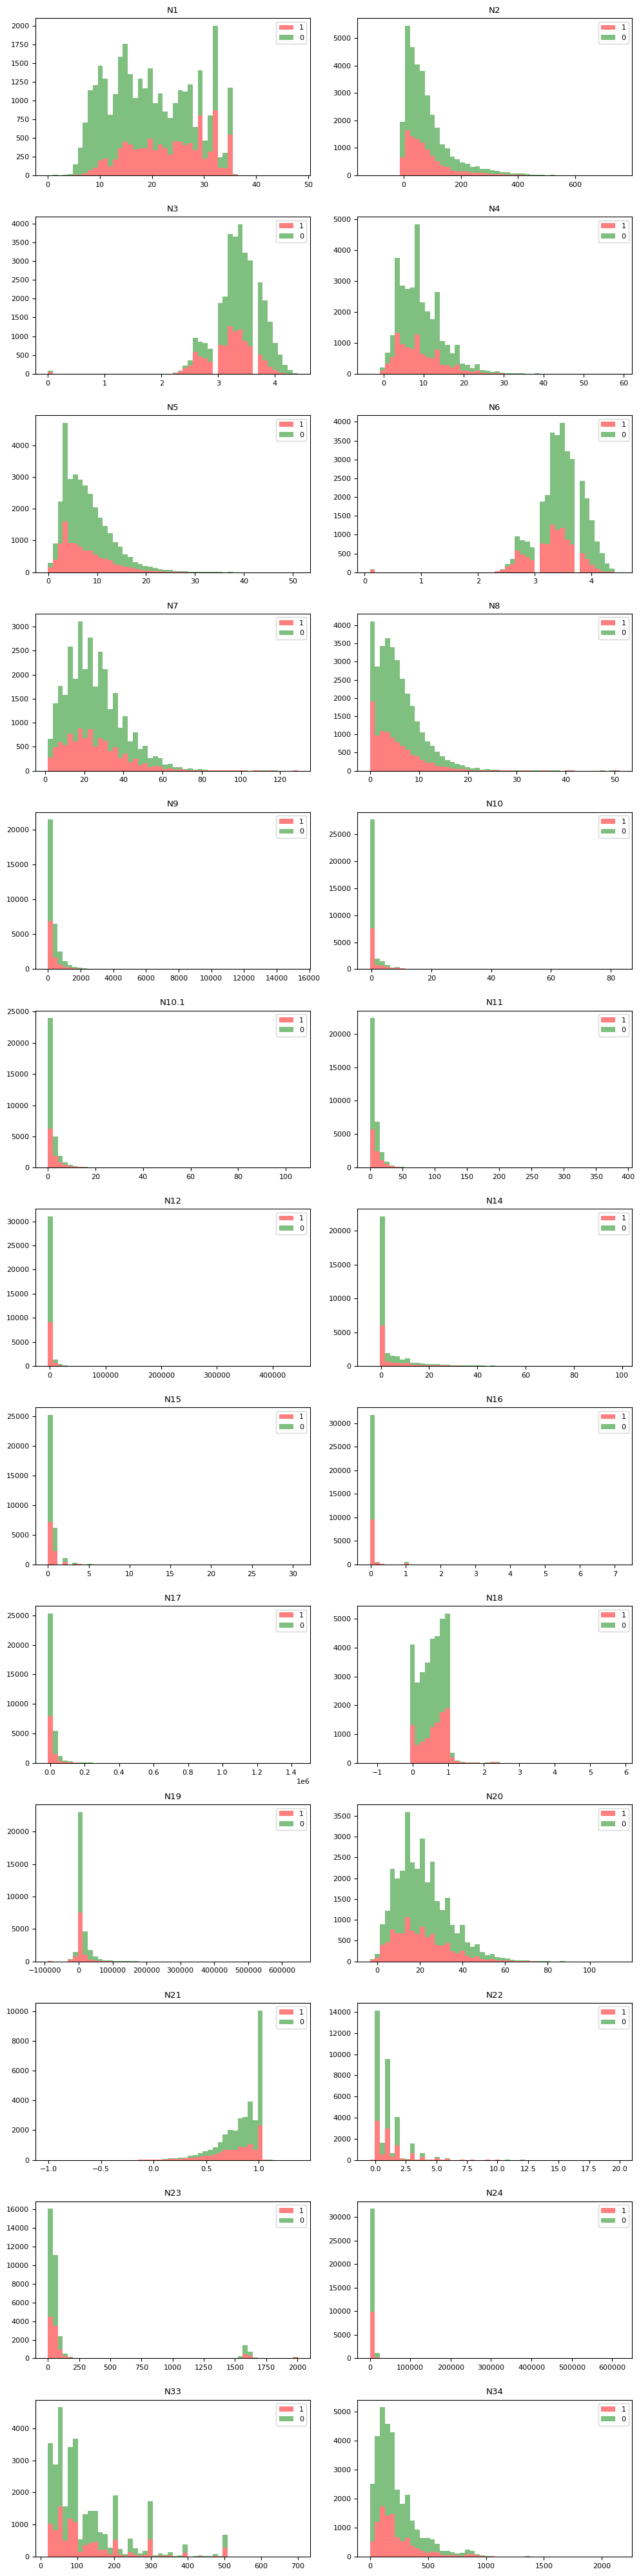

In [26]:
#Stack the data
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=13, ncols=2, figsize = (10, 40))
axes = axes.ravel()
for idx,ax in enumerate(axes):
    ax.figure
    binwidth= (max(df[features_mean[idx]]) - min(df[features_mean[idx]]))/50
    ax.hist([df_1[features_mean[idx]],df_0[features_mean[idx]]], bins=np.arange(min(df[features_mean[idx]]), max(df[features_mean[idx]]) + binwidth, binwidth) , alpha=0.5,stacked=True, label=[1,0],color=['r','g'])
    ax.legend(loc='upper right')
    ax.set_title(features_mean[idx])
plt.tight_layout()
plt.show()

#### Observations:
<br>For most of the numerical features, a higher value corresponds to **Dependent_Variable** being 0.

In [98]:
traindf, testdf = train_test_split(df, test_size = 0.3)

In [99]:
from sklearn.exceptions import ConvergenceWarning
import warnings

def cross_validate(predictors, target, dataset, model, scale_data=False, max_iter=100):
    # Split the dataset into features (X) and target (y)
    X = dataset[predictors]
    y = dataset[target]

    # Define the number of folds for cross-validation
    num_folds = 5

    # Initialize a KFold object with the desired number of folds
    kf = KFold(n_splits=num_folds)

    # Create empty lists to store the ROC AUC scores for each fold
    fold_scores = []

    # Perform K-fold cross-validation
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets for the current fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Scale the data if specified
        if scale_data:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        # Fit the model on the training data
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            model.max_iter = max_iter
            model.fit(X_train, y_train)

        # Make predictions on the test data
        if scale_data:
            X_test = pd.DataFrame(X_test, columns=predictors)  # Ensure feature names are included
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate the ROC AUC score for the current fold
        fold_score = roc_auc_score(y_test, y_pred_proba)
        fold_scores.append(fold_score)

    # Print the ROC AUC scores for each fold
    for fold, score in enumerate(fold_scores):
        print(f"Fold {fold+1} ROC AUC Score: {score}")

    # Print the average ROC AUC score across all folds
    avg_score = sum(fold_scores) / len(fold_scores)
    print('Average ROC AUC Score:', avg_score)


In [100]:
predictor_var = list(df.columns[2:])

In [101]:
outcome_var = 'Dependent_Variable'

In [102]:
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 25, max_depth = 15, max_features = 6)
cross_validate(predictor_var, outcome_var, df, model, scale_data = True)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Fold 1 ROC AUC Score: 0.7626203465982028
Fold 2 ROC AUC Score: 0.7588092425865685
Fold 3 ROC AUC Score: 0.7538026116200471
Fold 4 ROC AUC Score: 0.7515074878396035
Fold 5 ROC AUC Score: 0.7716405638991047
Average ROC AUC Score: 0.7596760505087052


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [103]:
model = XGBClassifier(random_state=0)
cross_validate(predictor_var, outcome_var, df, model, scale_data=True)

Fold 1 ROC AUC Score: 0.7574596705177578
Fold 2 ROC AUC Score: 0.7559698025662883
Fold 3 ROC AUC Score: 0.7524900428667631
Fold 4 ROC AUC Score: 0.7504669482219071
Fold 5 ROC AUC Score: 0.7672466771949739
Average ROC AUC Score: 0.7567266282735381


In [104]:
model = LGBMClassifier(random_state = 42)
cross_validate(predictor_var, outcome_var, df, model, scale_data=True)

Fold 1 ROC AUC Score: 0.7709828840393668
Fold 2 ROC AUC Score: 0.7642919580280095
Fold 3 ROC AUC Score: 0.7651163412970855
Fold 4 ROC AUC Score: 0.7634844278849945
Fold 5 ROC AUC Score: 0.7786939083452096
Average ROC AUC Score: 0.7685139039189333


#### Testing with SoftImpute

In [105]:
feature_df.iloc[:, 1:] = soft_imp_data.iloc[:, 1:].values

<ipython-input-105-06eae70734b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df.iloc[:, 1:] = soft_imp_data.iloc[:, 1:].values


In [106]:
df.loc[:, feature_df.columns] = feature_df.values

In [107]:
traindf, testdf = train_test_split(df, test_size = 0.3)

In [108]:
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 25, max_depth = 15, max_features = 6)
cross_validate(predictor_var, outcome_var, df, model, scale_data=True)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Fold 1 ROC AUC Score: 0.7634603123662815
Fold 2 ROC AUC Score: 0.7574850251625779
Fold 3 ROC AUC Score: 0.7545148367441642
Fold 4 ROC AUC Score: 0.7532542350609744
Fold 5 ROC AUC Score: 0.7687312096756103
Average ROC AUC Score: 0.7594891238019216


In [109]:
model = XGBClassifier(random_state=0)
cross_validate(predictor_var, outcome_var, df, model, scale_data=True)

Fold 1 ROC AUC Score: 0.7601068677792041
Fold 2 ROC AUC Score: 0.7541296956501989
Fold 3 ROC AUC Score: 0.7518508951745548
Fold 4 ROC AUC Score: 0.7533430774015832
Fold 5 ROC AUC Score: 0.7623484460741058
Average ROC AUC Score: 0.7563557964159294


In [110]:
model = LGBMClassifier(random_state = 42)
cross_validate(predictor_var, outcome_var, df, model, scale_data=True)

Fold 1 ROC AUC Score: 0.7711892918271288
Fold 2 ROC AUC Score: 0.7666623157273478
Fold 3 ROC AUC Score: 0.765173694555097
Fold 4 ROC AUC Score: 0.7632257224414242
Fold 5 ROC AUC Score: 0.7819551332866124
Average ROC AUC Score: 0.7696412315675221


Based on all possible outcomes, we'll use LGBMClassifier combined with IterativeImpute method for predicting outcomes on test dataset.

In [53]:
from sklearn.pipeline import Pipeline

In [54]:
numeric_pipeline = Pipeline(
    steps = [("impute", IterativeImputer()),
             ("scale", StandardScaler())]
)

In [55]:
test_df = pd.read_csv('X_test.csv')
test_df

,Unique_ID,C1,C2,C3,C4,C5,C6,C7,C8,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N10.1,N11,N12,N14,N15,N16,N17,N18,N19,N20,N21,N22,N23,N24,N25,N26,N27,N28,N29,N30,N31,N32,N33,N34,N35
0,Candidate_1602,1,0,0,23,0,True,0,True,18.00,NaN,3.2,NaN,NaN,3.295,27.0,2,0,3.0,3.0,12.0,NaN,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,90.38,23.0
1,Candidate_29650,1,0,2,4,2,True,2,True,16.75,107.0,3.7,7.0,4.0,3.795,19.0,4,522,0.0,1.0,6.0,0.0,0.0,0.0,0.0,59435.0,0.83,12165.0,19.0,0.94,2.0,36.0,5779.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.0,532.93,16.0
2,Candidate_31061,1,2,3,38,1,False,4,True,29.99,45.0,3.2,5.0,4.0,3.295,49.0,3,79,0.0,5.0,8.0,0.0,12.0,1.0,0.0,1996.0,0.79,504.0,34.0,0.70,2.0,48.0,3083.333333,1.0,6.0,6.0,0.0,0.0,5000.0,4334.59,-82.0,80.0,169.78,22.0
3,Candidate_5768,1,1,28,20,2,False,2,True,17.70,20.0,3.3,7.0,6.0,3.395,10.0,5,299,1.0,1.0,1.0,0.0,0.0,0.0,0.0,9281.0,0.84,1428.0,9.0,0.77,0.0,36.0,5117.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.0,270.02,13.0
4,Candidate_27059,1,1,15,1,3,False,5,False,28.00,2.0,3.0,20.0,18.0,3.095,34.0,12,396,0.0,0.0,2.0,0.0,0.0,0.0,0.0,13902.0,0.64,6324.0,25.0,0.92,2.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,103.41,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11012,Candidate_7453,1,0,3,0,2,True,1,True,15.00,50.0,3.5,7.0,7.0,3.595,32.0,4,133,2.0,4.0,13.0,100.0,1.0,0.0,0.0,3695.0,0.79,931.0,21.0,0.56,0.0,38.0,13000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.0,693.31,20.0
11013,Candidate_38211,1,0,0,40,0,False,0,True,18.00,NaN,2.8,NaN,NaN,2.895,2.0,1,15,1.0,1.0,7.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,36.15,10.0
11014,Candidate_25020,1,19,1,24,1,True,4,True,31.77,60.0,3.6,12.0,12.0,3.695,56.0,14,298,7.0,1.0,6.0,54550.0,58.0,1.0,0.0,5625.0,0.20,16987.0,43.0,0.70,2.0,48.0,2916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,173.71,22.0
11015,Candidate_44501,1,1,19,1,2,False,4,True,18.00,117.0,3.6,8.0,6.0,3.695,25.0,4,101,1.0,1.0,3.0,672.0,1.0,0.0,0.0,2412.0,0.35,4388.0,24.0,0.91,0.0,130.0,2592.333333,1.0,11.0,11.0,0.0,0.0,1200.0,0.00,-24.0,24.0,43.38,26.0


In [56]:
# Missing Ratio

all_data_na = (test_df.isnull().sum() / len(test_df))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending = False)
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data           # Ratio of data points for each column with null values

,Missing Ratio
N32,80.829627
N31,80.593628
N30,80.593628
N29,80.593628
N28,80.593628
N27,80.593628
N26,80.593628
N25,80.593628
N12,13.533630
N2,13.515476


In [57]:
test_df = test_df.drop(['N32', 'N31', 'N30', 'N29', 'N28', 'N27', 'N26', 'N25'], axis = 1)  # columns with greater than 80% missing values
test_df          # dropping columns as we don't have any domain knowledge

,Unique_ID,C1,C2,C3,C4,C5,C6,C7,C8,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N10.1,N11,N12,N14,N15,N16,N17,N18,N19,N20,N21,N22,N23,N24,N33,N34,N35
0,Candidate_1602,1,0,0,23,0,True,0,True,18.00,NaN,3.2,NaN,NaN,3.295,27.0,2,0,3.0,3.0,12.0,NaN,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,3333.333333,50.0,90.38,23.0
1,Candidate_29650,1,0,2,4,2,True,2,True,16.75,107.0,3.7,7.0,4.0,3.795,19.0,4,522,0.0,1.0,6.0,0.0,0.0,0.0,0.0,59435.0,0.83,12165.0,19.0,0.94,2.0,36.0,5779.833333,300.0,532.93,16.0
2,Candidate_31061,1,2,3,38,1,False,4,True,29.99,45.0,3.2,5.0,4.0,3.295,49.0,3,79,0.0,5.0,8.0,0.0,12.0,1.0,0.0,1996.0,0.79,504.0,34.0,0.70,2.0,48.0,3083.333333,80.0,169.78,22.0
3,Candidate_5768,1,1,28,20,2,False,2,True,17.70,20.0,3.3,7.0,6.0,3.395,10.0,5,299,1.0,1.0,1.0,0.0,0.0,0.0,0.0,9281.0,0.84,1428.0,9.0,0.77,0.0,36.0,5117.083333,150.0,270.02,13.0
4,Candidate_27059,1,1,15,1,3,False,5,False,28.00,2.0,3.0,20.0,18.0,3.095,34.0,12,396,0.0,0.0,2.0,0.0,0.0,0.0,0.0,13902.0,0.64,6324.0,25.0,0.92,2.0,NaN,0.000000,50.0,103.41,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11012,Candidate_7453,1,0,3,0,2,True,1,True,15.00,50.0,3.5,7.0,7.0,3.595,32.0,4,133,2.0,4.0,13.0,100.0,1.0,0.0,0.0,3695.0,0.79,931.0,21.0,0.56,0.0,38.0,13000.000000,400.0,693.31,20.0
11013,Candidate_38211,1,0,0,40,0,False,0,True,18.00,NaN,2.8,NaN,NaN,2.895,2.0,1,15,1.0,1.0,7.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5000.000000,20.0,36.15,10.0
11014,Candidate_25020,1,19,1,24,1,True,4,True,31.77,60.0,3.6,12.0,12.0,3.695,56.0,14,298,7.0,1.0,6.0,54550.0,58.0,1.0,0.0,5625.0,0.20,16987.0,43.0,0.70,2.0,48.0,2916.666667,80.0,173.71,22.0
11015,Candidate_44501,1,1,19,1,2,False,4,True,18.00,117.0,3.6,8.0,6.0,3.695,25.0,4,101,1.0,1.0,3.0,672.0,1.0,0.0,0.0,2412.0,0.35,4388.0,24.0,0.91,0.0,130.0,2592.333333,24.0,43.38,26.0


In [62]:
feature_cols = list(test_df.columns[1:])

In [63]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_pipeline, feature_cols)
    ]
)

In [64]:
X_processed = full_processor.fit_transform(test_df)
X_processed

array([[-0.30655719, -0.7225197 , -1.07687046, ..., -0.71979464,
        -0.71976768,  0.46864373],
       [-0.30655719, -0.7225197 , -0.90970643, ...,  1.67284989,
         1.66690731, -0.49074955],
       [-0.30655719, -0.1359749 , -0.82612442, ..., -0.4326773 ,
        -0.29156297,  0.33158754],
       ...,
       [-0.30655719,  4.84965593, -0.99328845, ..., -0.4326773 ,
        -0.27036846,  0.33158754],
       [-0.30655719, -0.4292473 ,  0.51118781, ..., -0.96862968,
        -0.97323899,  0.87981228],
       [-0.30655719, -0.4292473 , -0.49179636, ..., -0.81550042,
        -0.91537203,  1.29098082]])

In [111]:
model = LGBMClassifier()

In [140]:
feature_df.iloc[:, 1:] = imputed_data.iloc[:, 1:].values

<ipython-input-140-bce9ac0f90cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df.iloc[:, 1:] = imputed_data.iloc[:, 1:].values


In [141]:
df.loc[:, feature_df.columns] = feature_df.values

In [142]:
X_train = df[predictor_var]
y_train = df[outcome_var]

In [147]:
X_train = full_processor.fit_transform(X_train)
X_train

array([[-0.30001403, -0.70723519, -0.15450381, ..., -0.64785107,
        -0.59472912, -1.0324793 ],
       [-0.30001403,  0.46959106, -0.90367504, ...,  0.32925083,
         0.20259641, -0.34896564],
       [-0.30001403, -0.70723519,  0.51142616, ..., -0.97355171,
        -0.93304693, -0.21226291],
       ...,
       [-0.30001403, -0.41302863, -0.90367504, ..., -0.82028082,
        -0.86173747,  0.06114255],
       [-0.30001403, -0.70723519, -1.07015754, ..., -0.97355171,
        -0.97963935, -0.34896564],
       [-0.30001403,  1.05800418, -0.40422756, ..., -0.24551499,
        -0.10837717, -1.16918204]])

In [148]:
model.fit(X_train, y_train)

LGBMClassifier()

In [149]:
output = pd.DataFrame(model.predict_proba(X_processed), columns = model.classes_)
output.rename(columns = {1:'Class_1_probability'}, inplace = True)
output

,0,Class_1_probability
0,0.600282,0.399718
1,0.693097,0.306903
2,0.609796,0.390204
3,0.814935,0.185065
4,0.569736,0.430264
...,...,...
11012,0.529522,0.470478
11013,0.856295,0.143705
11014,0.598854,0.401146
11015,0.789965,0.210035


In [151]:
submission = pd.DataFrame({ 'Unique_ID': test_df.Unique_ID.values, 'Class_1_probability': output.Class_1_probability.values })
submission.set_index('Unique_ID', inplace = True)
submission.to_csv('final_predictions.csv')